###Import all packages

In [1]:
import sys
sys.path.append("..") 

In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import os
import torch.cuda
import albumentations as albu
import segmentation_models_pytorch as smp
from  segmentation_models_pytorch.utils.base import Metric
from segmentation_models_pytorch.base.modules import Activation
from collections import defaultdict
import nibabel as nib
from tqdm import tqdm
from Utils.dataset_utils import *

ModuleNotFoundError: No module named 'albumentations'

In [ ]:
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
VOLUMES_BASE_PATH=Path(r'G:\ML Project Datasets\Medical Image\MM-WH 2017 Dataset')
LABELS_TO_KEEP=[600,420,550,205]

In [ ]:
os.listdir(VOLUMES_BASE_PATH)

In [3]:
WIDTH=512
HEIGHT=512

In [57]:
def normalize(data):
    data=(data-np.min(data))/(np.max(data)-np.min(data))
    return data
def load_volume(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    label = None
    vol = (nib.load(image_nifty_file))
    image=np.array(vol.get_fdata())
    affine=vol.affine
    if os.path.exists(label_nifty_file):
        label = np.array(nib.load(label_nifty_file).get_fdata())
    return image, label,affine
def convert_labels(label_volume):
    new_labels=np.zeros(label_volume.shape)
    for lbl in np.unique(label_volume):
        if lbl in LABELS_TO_KEEP:
            new_labels[np.where(label_volume==lbl)]=1
    return new_labels

def to_tensor(x, **kwargs): 
    x= torch.from_numpy(x.transpose(2, 0, 1).astype('float32'))
    return x

def create_folder(path):
    if os.path.exists(path)==False:
        os.mkdir(path)
    

In [58]:
def predict_img(model,img):
    img=preprocessing_fn(img)
    img=to_tensor(img)
    img = img.to(device=DEVICE)
    img=torch.unsqueeze(img,dim=0)
    pred_mask=torch.squeeze(model(img))
    pred_mask=pred_mask.detach().cpu().numpy()
    return pred_mask
def predict_volume(model,volume):
    pred_vol=np.zeros(volume.shape)
    X,Y,Z=volume.shape
    for i in tqdm(range(Z)):
        img=normalize(volume[:,:,i])
        img = img*255
        img =img.astype('uint8')
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
        pred_mask=predict_img(model,img)
        pred_vol[:,:,i]=pred_mask
        
    return pred_vol

In [74]:
# Model to choose
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'
MODEL_NAME='UNET'
BEST_WEIGHTS=r'G:\Projects and Work\Mouse Heart Segmentation\Trained Weights - Human Heart\Unet_se_resnext50_32x4d\best_29_0.074.pt'
OUTPUT_PATH=Path(r'G:\Projects and Work\Mouse Heart Segmentation\Trained Weights - Human Heart\Unet_se_resnext50_32x4d\Outputs')
create_folder(OUTPUT_PATH)

In [75]:
# Load model
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
best_model = torch.load(BEST_WEIGHTS)

In [76]:
# function to save numpy volume array to .nii
def save_mask_nii(volume_arr,affine,path):
    ni_img = nib.Nifti1Image(volume_arr,affine)
    nib.save(ni_img, path)

In [78]:
# Run a model on all volumes
subjects = os.listdir(VOLUMES_BASE_PATH/'volumes')
subject_labels = os.listdir(VOLUMES_BASE_PATH/'labels')
for i in range(len(subjects)):
    subject_path = os.path.join(VOLUMES_BASE_PATH,'volumes',subjects[i])
    subject_name = subjects[i].split(".")[0]
    create_folder(os.path.join(OUTPUT_PATH,subject_name))
    # Load volume with its affine and mask
    volume, volume_gt_mask,affine = load_volume(subject_path,VOLUMES_BASE_PATH/'labels'/subject_labels[i])
    volume_gt_mask=convert_labels(volume_gt_mask)
    # Predict volume
    volume_pred_mask=predict_volume(best_model,volume)
    volume_pred_mask=np.round(volume_pred_mask)
    #save predicted volume
    save_mask_nii(volume_pred_mask,affine,OUTPUT_PATH/subject_name/'prediction_mask.nii.gz')
    # save grouth truth .nii file also for convinience
    if volume_gt_mask is not None:
        save_mask_nii(volume_gt_mask,affine,OUTPUT_PATH/subject_name/'ground_truth_mask.nii.gz')

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [00:30<00:00, 16.85it/s]


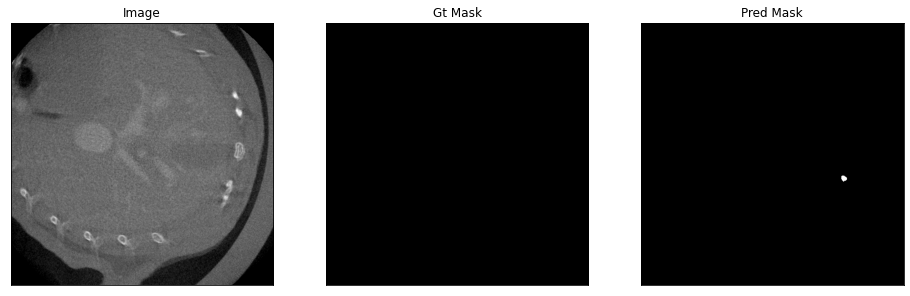

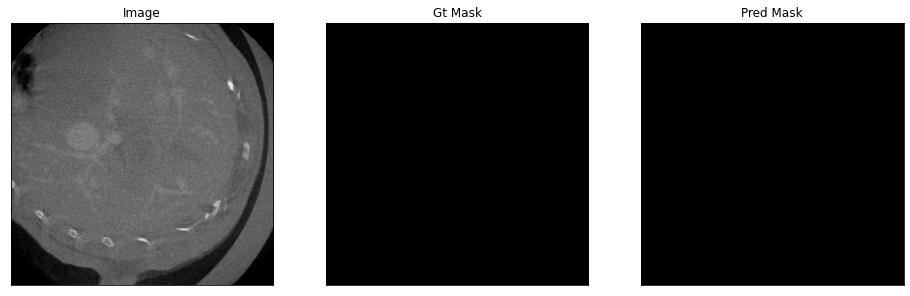

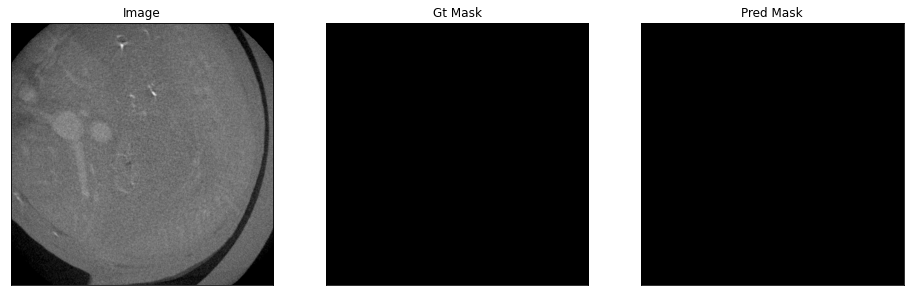

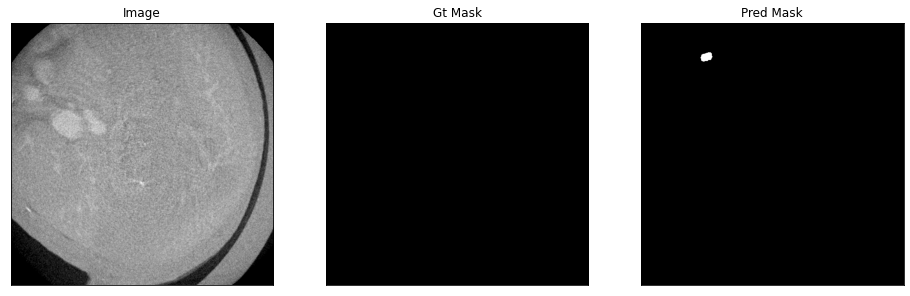

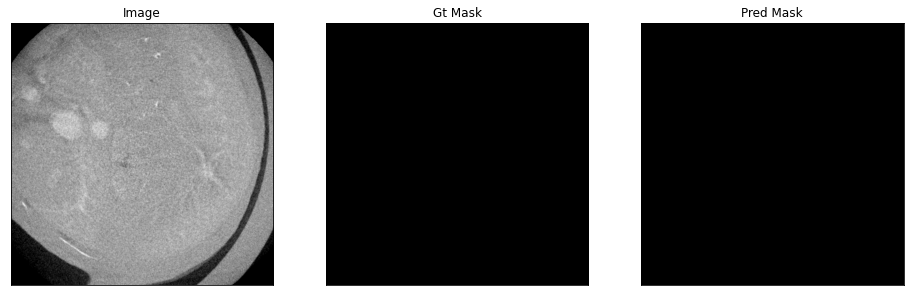

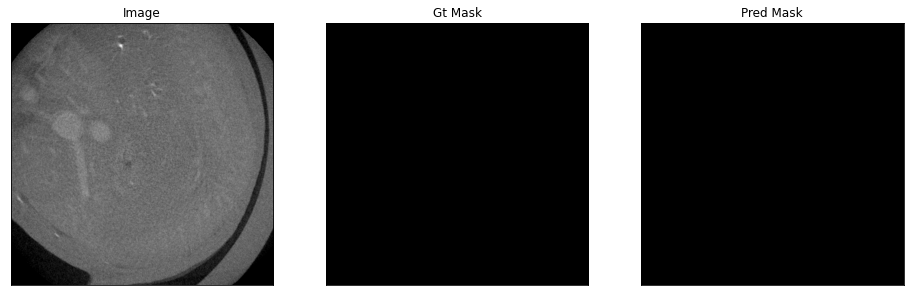

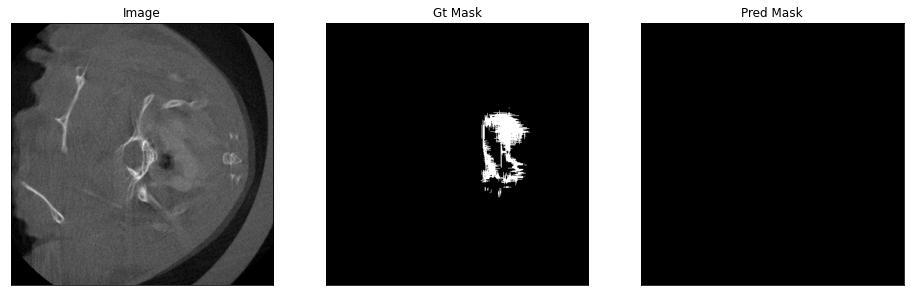

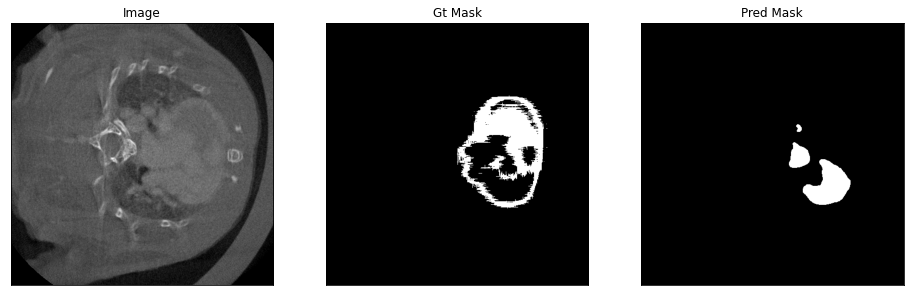

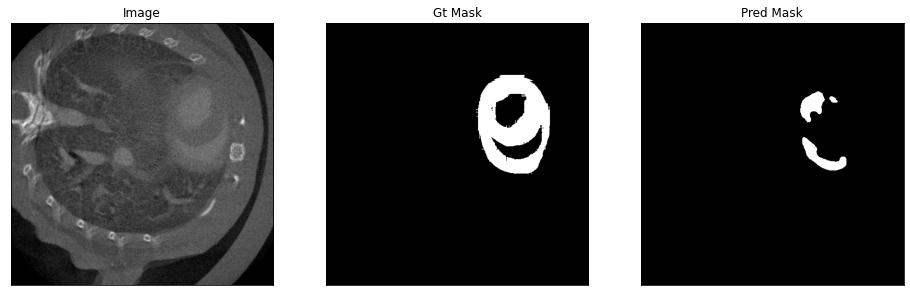

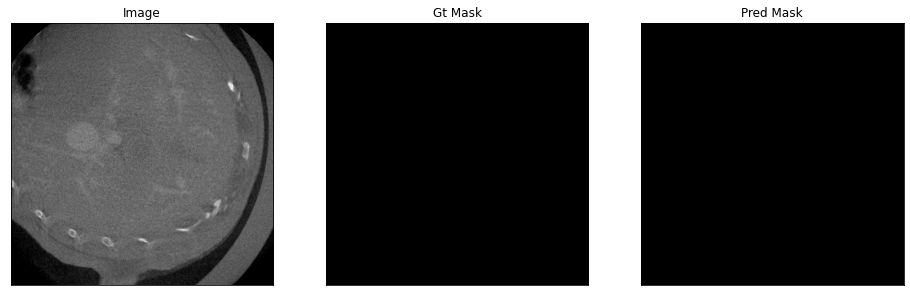

In [64]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap="gray")
    plt.show()

for i in range(10):
    n = np.random.choice(volume_pred_mask.shape[2])
    visualize(image=volume[:,:,n],gt_mask= volume_gt_mask[:,:,n],pred_mask=volume_pred_mask[:,:,n])
